# Variogram Analysis

Variograms are a way to describe the spatial variability in a dataset

https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram.htm

In [2]:
from skgstat import Variogram
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from datetime import datetime as dt
import xarray as xr
import numpy as np
from math import floor

plt.style.use('ggplot')
np.random.seed(42)
coordinates = np.random.gamma(20, 5, (50,2))
np.random.seed(42)
values = np.random.normal(20, 5, 50)

## Full Dataset Variogram

Without knowing much about what our dataset looks like or how much spatial correlation to expect, we decided to first select random points from the entire extent of the dataset and throw them into a variogram to see what it looked like. The following code uses only one layer (ie one set of snow depths from a specific date) from our dataset and selects a single group of random points, but we ran it several times selecting different groups of random points and extracting snow depth at these points from several different layers.

In [10]:
# Read the 2015 snowdepth dataset into an xarray structure
files = glob('/srv/shared/deep_stac/data/snowdepth/netcdf/2015/*int*')
dates = [dt.strptime(os.path.basename(f).split('_')[0], '%Y%m%d').strftime('%-m/%-d/%Y') for f in files]
snowdepth = xr.open_mfdataset(files, concat_dim='flight_date', chunks={'x':1000, 'y':1000})
snowdepth.close()

# Also read in a mask to exclude any data points outside the boundaries of the basin
topo = xr.open_mfdataset('/srv/shared/deep_stac/data/topo.nc', chunks={'x': 1000, 'y': 1000})
topo.close()
mask = topo['mask'] == 1

In [11]:
# Select date to use for analysis
print(f"Available dates: {', '.join(sorted(dates))}")
snowdepth_layer = dates.index(input("Enter one :"))

Available dates: 2/18/2015, 3/25/2015, 3/6/2015, 4/15/2015, 4/27/2015, 4/3/2015, 4/9/2015, 5/1/2015, 5/28/2015, 6/8/2015


Enter one : 4/15/2015


We selected 1,000 random points from within the boundaries of the basin, excluding points outside the Tuolomne Basin using the mask. 

Our method for selecting points was a little hacky - there might be a smoother way of doing this, but we wanted to use a method that was fast and didn't require holding all the potential locations in memory. We thought of the raster as a 1D array (like if you take each row and align them in one long list), selected random values within the length of this array, and then converted those values back into 2D format.

In [14]:
# total number of cells in a single layer of our dataset
y_length = snowdepth.Band1.shape[1]
x_length = snowdepth.Band1.shape[2]
num_obs = x_length * y_length

# take random sample of 3,000 points total so we can be sure we'll have at least 1,000 after excluding masked locations
np.random.seed(42)
locs_flat = [int(i * num_obs) for i in np.random.random_sample((3000,))]
locs = [(floor(i / x_length), i % x_length) for i in locs_flat]

In [15]:
# extract snow depth values from each location in the random sample that falls within the basin boundaries
locs = [loc for loc in locs if mask[loc]][:1000]
values = [snowdepth.Band1[5, loc[0], loc[1]].values.item() for loc in locs]    

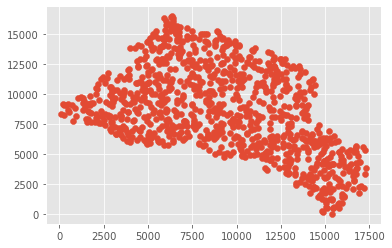

In [16]:
# plot selected random points
x, y = list(zip(*locs))[1], list(zip(*locs))[0]
y = [17001 - yval for yval in y]
plt.scatter(x, y)

We create a variogram using our locations and the values at each location. We have several options for some parameters.

* `estimator` the equation used to calculate variance
* `model` the type of equation that will be fitted to the variance
* `maxlag` the maximum distance between points that we'll examine
* `n_lags` the number of bins that we'll sort the data into before fitting the model

Using various functions within the variogram object, we can visualize the raw distance differences between our points, the average variances in each bin, and the model fitted to these variances.

In [21]:
V = Variogram(coordinates=np.array(locs), values=values, estimator="matheron", model="gaussian", maxlag=8000, n_lags=100)
print(V)

gaussian Variogram
------------------
Estimator:         matheron
Effective Range:   1414670.22
Sill:              7001083.23
Nugget:            0.00
        


Each blue point below represents the distance (x-axis) and difference in snow depth (y-axis) between two of our input points. The red lines represent the dividors between bins - we're leaving out the points that are farthest from each other (> 8,000 cells, or > 24,000 meters).

The distance vs. snowdepth difference plot has an interesting but uncommon structure. Many point pairs have the same differences in snow depth, most likely due to the fact that our raw snow depth data had been converted to centimeter integers to save space.

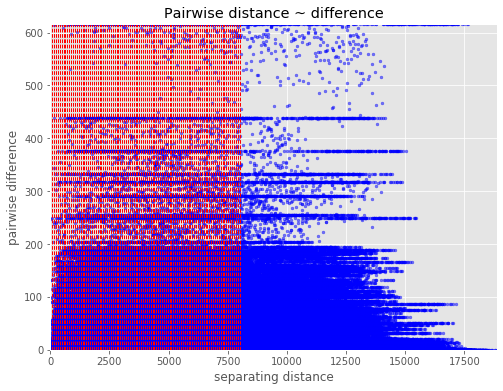

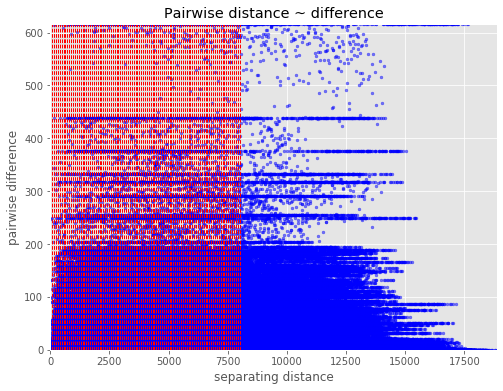

In [27]:
V.distance_difference_plot()

Each blue point below represents the average variance (y-axis) for each bin (x-axis, proportion of the maximum lag). The green line represents the model fitted to the points. 

We see that the spatial variance increases until a lag of about 0.3 x `maxlag`, which is 2400 cells or 7.2 km. This distance is too large for us to use for input into our neural network, but we don't have enough data at smaller distances to tell if there's a smaller range of distances with even lower variance. 

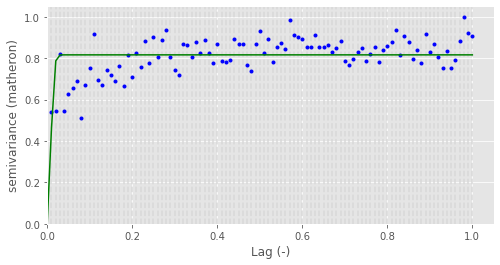

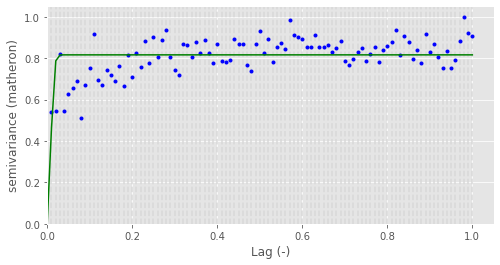

In [28]:
V.plot(hist=False)

SIDE NOTE: We can see that our fitted model isn't a great fit for our data - often in variogram analysis composite models will be used, with one model fitted to a range of shorter distances and another to the longer distances. One disadvantage to using a python module like scikit-gstat is that they apply the same methods to all the data you give them, with only a few options for fine-tuning. 

For our analysis we aren't too worried about the exact model that gets fit to our data because our main goal is estimating the range of distances with higher spatial correlation, and we can see that just by looking at the general trend of the points.

For further work into fitting a better model to our points, we could extract the variances and the bins from the variogram object and do our own model fitting.

In [26]:
V.experimental, V.bins

(array([1577.66666667, 1594.60135135, 2408.43194444, 1602.36334746,
        1840.13009404, 1914.93867334, 2016.53333333, 1502.97386588,
        1960.40284553, 2200.89686469, 2686.45324768, 2029.44816054,
        1963.09803319, 2174.56628674, 2103.89516129, 2013.26135784,
        2226.48468876, 1948.01694118, 2391.76891892, 2078.97115385,
        2414.12319763, 2223.25992707, 2579.93828125, 2273.65719064,
        2636.19667283, 2357.12      , 2601.16065748, 2743.15753194,
        2353.94934211, 2181.69407234, 2111.08335995, 2550.30687241,
        2535.49587534, 2364.48069964, 2566.93355724, 2417.98920023,
        2598.06987847, 2410.83171706, 2280.06744251, 2537.59754396,
        2299.37880496, 2294.56985975, 2310.44278953, 2614.1592013 ,
        2547.78777269, 2545.83095114, 2246.23422014, 2164.11276128,
        2543.30618935, 2724.81469158, 2421.57825868, 2612.82688417,
        2293.34217913, 2502.77006925, 2551.5947328 , 2468.4965526 ,
        2875.96792453, 2667.32394541, 2648.45989

# Local Variogram

In order to examine spatial variance at smaller distances than we have above, we re-ran our code on a smaller subset of the original raster. For the neural network, we're looking specifically at a 4,000 x 4,000 cells near the middle of the raster, so we use this for our local variogram analysis.

In [30]:
snowdepth_sub = snowdepth.Band1[:,10000:14000,10000:14000]

In [46]:
# total number of cells in a single layer of our dataset
y_length = snowdepth_sub.shape[1]
x_length = snowdepth_sub.shape[2]
num_obs = x_length * y_length

# take random sample of 3,000 points total so we can be sure we'll have at least 1,000 after excluding masked locations
np.random.seed(42)
locs_flat = [int(i * num_obs) for i in np.random.random_sample((1000,))]
locs = [(floor(i / x_length), i % x_length) for i in locs_flat]

In [47]:
# extract snow depth values from each location in the random sample (we know our subset raster falls entirely within 
# the boundaries of the basin so we don't need to exclude any using the mask)
values = [snowdepth_sub[5, loc[0], loc[1]].values.item() for loc in locs]   

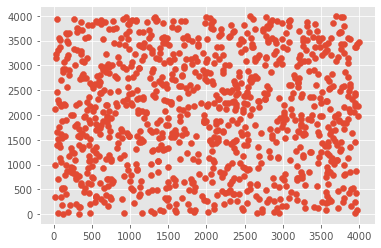

In [48]:
plt.scatter(*list(zip(*locs)))

In [ ]:
V = Variogram(coordinates=np.array(locs), values=values_, estimator="matheron", model="gaussian", maxlag=1000, n_lags=50)

In [ ]:
V.distance_difference_plot()

In [ ]:
V.plot(hist=False)